# Data science project in Python - Voorspellingen maken met features

Doormiddel van numpy, pandas, matplotlib & SciKit-learn

Door Louis D'Hont - Elektronica-ICT - 2021

Dit project is het tweede deel van het data science project. Bekijk 'project-deel-1' om het data cleaning proces te zien.

In [1]:
# Importeren van gebruikte bibliotheken
import datetime
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

### Inlezen features

Onderstaande code leest het 'featuresDataFrame' bestand in en zet deze om naar een dataframe. In deel 1 van het project is er nog een aanpassing gebeurd, de kolom 'Geboortedatum' werdt alsnog meegenomen als feature om hierna verdere berekeningen te kunnen doen.

In [2]:
features = pd.read_csv("featuresDataFrame.csv", sep=',') 
features = features.drop(['Unnamed: 0'], axis=1)

### Bestemmingen omzetten
    
De bestemmingen data is door het bedrijf manueel ingevoerd. Om de bestemmingen te kunnen koppelen aan een land heb  ik gekozen om elk land om te zetten naar een cijfer. Deze onderstaande lijst toont de eerste 10 landen met hun cijfer. Heel wat reizen bevatte geen directe aanwijzing naar het land maar had vaak een bekende stad of streek in de omschrijving, door deze te gaan groeperen konden alle bestemmingen worden omgezet naar hun coresponderende cijfer. Een 20 tal waarden bevatte geen duidelijke aanwijzing naar een land of streek. Hiervoor is besloten om deze toe te wijzen aan het land waar de meeste reizen naartoe gingen, met name Frankrijk).

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Portugal
- 6 Ijsland
- 7 Italië
- 8 Ierland
- 9 De Verenigde Staten
- 10 Jordanië

In [3]:
nederland = ['friese', 'nederland', 'vlieland', 'brabant', 'twente', 'drenthe', 'limburg', 'brabantse', 'nederlands', 'duinen', 'salland', 'zeeland', 'ijslanders']
belgie = ['ardennen', 'belgium', 'ardenne', 'belgië', 'belgie', 'arrdennen', 'eifel', 'ardennen', 'ardenen']
frankrijk = ['frankrijk', 'mont saint michel', 'morvan', 'dartmoor', 'couleurs corse', 'vogezen', 'margeride', 'haute valee', 'jura', 'normandië', 'médoc', 'montmorillonnais', 'france', 'loire', 'wijnroute', 'wijngaarden', 'elzas', 'pyreneeën', 'dordogne', 'pyreneeen', 'corsica', 'aude', 'frans', 'armagnac', 'frankrijjk', 'frankijk']
duitsland = ['germany', 'duitsland', 'thuringen', 'beieren', 'duitsand', 'duitse', 'thüringen']
spanje = ['spain', 'spanje', 'sulayr', 'alpujarra', 'middellandse', 'demanda', 'monfrague', 'andalusisch', 'costa brava', 'sierra nevada', 'catalonië','catalonie', 'gredos', 'andalusië', 'ronda', 'andalusie', 'conquistadores']
italie = ['italy', 'italie', 'sicilië', 'madonie', 'italië', 'sardinië', 'sardinie', 'toscane', 'molise', 'alta maremma', 'molise abruzzen']
portugal = ['portugal', 'lusitano', 'faro', 'algarve', 'lissabon', 'portugese', 'azoren']
usa = ['verenigde staten', 'montana', 'usa', 'united states', 'wyoming', 'ranch', 'colorado']
kroatie = ['kroatie', 'croatia', 'kroatië', 'istrië', 'plitvice', 'rode-meer', 'dalmatie', 'istrie']
allerlei = ['Klassieke dressuur van topkwaliteit en stedenschoon', 'Avontuurlijke trektocht door een sprookjesachtig gebied', 'Trektocht in het spoor van de tuimelaar-dolfijn ',
       'Driedaagse trektocht in het land van d\x19Oc en d\x19Oil', 'Trektocht over de bergen naar de zee', 'Trektocht in het spoor van de tuimelaar-dolfijn','Paardrijden langs de route van de bandieten', 'De \x18Great Trek\x19: werkelijk avontuurlijke trektocht',
       'Beach and Bush Rides', 'Dressuurweek','Een week paardrijden met jongvolwassenen','National Park: paardrijden voor pure ontspanning',
       'Driedaagse tocht door de Vienne-vallei','Trektocht naar de gouden stranden', 'Oman','Trektocht tussen zee en woestijnbergen', 'Programma Full','Smokkelaarstocht', 'Trektocht over de bergen naar zee','Beach and Meadows trektocht','De "legendes van de Wolf"-trektocht','Standplaatsvakantie Stertochten', 'nan']

def convert_bestemmingen():
    for index, row in enumerate(features['Bestemming']):
        if any(ext in (str(row).lower()) for ext in belgie):
            features['Bestemming'].iloc[index] = 1
        elif any(ext in (str(row).lower()) for ext in nederland):
            features['Bestemming'].iloc[index] = 2
        elif any(ext in (str(row).lower()) for ext in frankrijk):
            features['Bestemming'].iloc[index] = 3
        elif any(ext in (str(row).lower()) for ext in duitsland):
            features['Bestemming'].iloc[index] = 4
        elif any(ext in (str(row).lower()) for ext in portugal):
            features['Bestemming'].iloc[index] = 5
        elif any(ext in (str(row).lower()) for ext in ['ijsland', 'iceland', 'geysir', 'golden circle']):
            features['Bestemming'].iloc[index] = 6
        elif any(ext in (str(row).lower()) for ext in italie):
            features['Bestemming'].iloc[index] = 7
        elif any(ext in (str(row).lower()) for ext in ['ierland', 'ireland', 'galway', 'ierse', 'donegal']):
            features['Bestemming'].iloc[index] = 8
        elif any(ext in (str(row).lower()) for ext in usa):
            features['Bestemming'].iloc[index] = 9
        elif any(ext in (str(row).lower()) for ext in ['jordanie', 'jordan', 'wadi rum']):
            features['Bestemming'].iloc[index] = 10
        elif any(ext in (str(row).lower()) for ext in spanje):
            features['Bestemming'].iloc[index] = 11
        elif any(ext in (str(row).lower()) for ext in ['botswana']):
            features['Bestemming'].iloc[index] = 12
        elif any(ext in (str(row).lower()) for ext in ['canada', 'yukon', 'alberta', 'saskatchewan']):
            features['Bestemming'].iloc[index] = 13
        elif any(ext in (str(row).lower()) for ext in ['roemenie', 'roemenië', 'transsylvanie', 'transsylvanië']):
            features['Bestemming'].iloc[index] = 14
        elif any(ext in (str(row).lower()) for ext in ['chili', 'chile']):
            features['Bestemming'].iloc[index] = 15
        elif any(ext in (str(row).lower()) for ext in ['marokko', 'marokkaanse', 'berbers']):
            features['Bestemming'].iloc[index] = 16
        elif any(ext in (str(row).lower()) for ext in ['griekenland', 'petra', 'kreta', 'kefalonia']):
            features['Bestemming'].iloc[index] = 17
        elif any(ext in (str(row).lower()) for ext in ['zuid afrika', 'afrika']):
            features['Bestemming'].iloc[index] = 18
        elif any(ext in (str(row).lower()) for ext in ['bulgarije', 'bulgaria', 'balkan']):
            features['Bestemming'].iloc[index] = 19
        elif any(ext in (str(row).lower()) for ext in ['hongarije', 'poesta', 'homgarije']):
            features['Bestemming'].iloc[index] = 20
        elif any(ext in (str(row).lower()) for ext in ['tsjechie', 'tsjechië', 'zuid-bohemen', 'karpaten']):
            features['Bestemming'].iloc[index] = 21   
        elif any(ext in (str(row).lower()) for ext in ['cappadocië', 'turkije', 'turklije', 'thracians']):
            features['Bestemming'].iloc[index] = 22
        elif any(ext in (str(row).lower()) for ext in ['polen', 'poolse', 'poland']):
            features['Bestemming'].iloc[index] = 23
        elif any(ext in (str(row).lower()) for ext in ['namibie', 'namibië']):
            features['Bestemming'].iloc[index] = 24
        elif any(ext in (str(row).lower()) for ext in ['kirgizie', 'kirgizië']):
            features['Bestemming'].iloc[index] = 25
        elif any(ext in (str(row).lower()) for ext in ['montenegro']):
            features['Bestemming'].iloc[index] = 26
        elif any(ext in (str(row).lower()) for ext in ['zweden']):
            features['Bestemming'].iloc[index] = 27
        elif any(ext in (str(row).lower()) for ext in ['albanie', 'albanië', 'katharen']):
            features['Bestemming'].iloc[index] = 28
        elif any(ext in (str(row).lower()) for ext in ['mongolië', 'mongolie', 'mongoolse']):
            features['Bestemming'].iloc[index] = 29
        elif any(ext in (str(row).lower()) for ext in kroatie):
            features['Bestemming'].iloc[index] = 30
        elif any(ext in (str(row).lower()) for ext in ['costa rica']):
            features['Bestemming'].iloc[index] = 31
        elif any(ext in (str(row).lower()) for ext in ['slowakije']):
            features['Bestemming'].iloc[index] = 32
        elif any(ext in (str(row).lower()) for ext in ['brazilie', 'santa catarina gaucho']):
            features['Bestemming'].iloc[index] = 33
        elif any(ext in (str(row).lower()) for ext in ['denemarken', 'denmark', 'deense']):
            features['Bestemming'].iloc[index] = 34
        elif any(ext in (str(row).lower()) for ext in ['noorwegen', 'norway', 'ramsjo-special', 'northern', 'scandinavische']):
            features['Bestemming'].iloc[index] = 35
        elif any(ext in (str(row).lower()) for ext in ['azerbidjan']):
            features['Bestemming'].iloc[index] = 36
        elif any(ext in (str(row).lower()) for ext in ['georgie', 'georgië', 'georgia']):
            features['Bestemming'].iloc[index] = 37
        elif any(ext in (str(row).lower()) for ext in ['zwitserland']):
            features['Bestemming'].iloc[index] = 38
        elif any(ext in (str(row).lower()) for ext in ['groot-brittanie', 'wales', 'britain', 'engeland']):
            features['Bestemming'].iloc[index] = 39
        elif any(ext in (str(row).lower()) for ext in ['argentinie', 'argentinië', 'noord-argentinië']):
            features['Bestemming'].iloc[index] = 40
        elif any(ext in (str(row).lower()) for ext in ['cuba']):
            features['Bestemming'].iloc[index] = 41
        elif any(ext in (str(row).lower()) for ext in ['lapland', 'finland']):
            features['Bestemming'].iloc[index] = 42
        elif any(ext in (str(row).lower()) for ext in ['mexico']):
            features['Bestemming'].iloc[index] = 43
        elif any(ext in (str(row).lower()) for ext in ['china']):
            features['Bestemming'].iloc[index] = 44
        elif any(ext in (str(row).lower()) for ext in ['kenia']):
            features['Bestemming'].iloc[index] = 45
        elif any(ext in (str(row).lower()) for ext in ['iran']):
            features['Bestemming'].iloc[index] = 46
        elif any(ext in (str(row).lower()) for ext in ['servië', 'servie', 'sumadija']):
            features['Bestemming'].iloc[index] = 47
        elif any(ext in (str(row).lower()) for ext in ['schotland']):
            features['Bestemming'].iloc[index] = 48
        elif any(ext in (str(row).lower()) for ext in ['egypte', 'sahara']):
            features['Bestemming'].iloc[index] = 49
        elif any(ext in (str(row).lower()) for ext in ['andorra']):
            features['Bestemming'].iloc[index] = 50
        elif any(ext in (str(row).lower()) for ext in ['uruguay']):
            features['Bestemming'].iloc[index] = 51
        elif any(ext in (str(row).lower()) for ext in ['rusland']):
            features['Bestemming'].iloc[index] = 52
        elif any(ext in (str(row).lower()) for ext in ['columbia', 'colombiaans']):
            features['Bestemming'].iloc[index] = 53
        elif any(ext in (str(row).lower()) for ext in ['australie']):
            features['Bestemming'].iloc[index] = 54
        elif any(ext in str(row) for ext in allerlei):
            features['Bestemming'].iloc[index] = 3
    return features['Bestemming'] 

features['Bestemming'] == convert_bestemmingen()
features['Bestemming'] = features['Bestemming'].astype(int)


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


De onderstaande code zet de geboortedatum om naar de huidige leeftijd, de lege waarden worden opgevult met een gemiddelde leeftijd van 40 jaar omdat er kan vanuit worden gegaan dat de gemiddelde persoon 40 jaar is.

In [4]:
features['Geboortedatum'] = pd.to_datetime(features['Geboortedatum'], errors = 'coerce')
features['Leeftijd'] = datetime.datetime.now().year - pd.DatetimeIndex(features['Geboortedatum']).year
features['Leeftijd'] = features['Leeftijd'].fillna(40)
features['Leeftijd'].astype(int);

### Omzetten van datatypes

De opgeslagen data is bij het inlezen opnieuw van het type int64, float64 en object. De data dat hiervoor een timedelta was ('Aantal dagen tot vertrek' en de 'Aantal dagen op reis' kolom) moet worden omgezet zodat er terug met kan worden gewerkt.

Elk land werdt omgezet in een cijfer. De onderstaande lijst toont de eerste 5 landen met hun coresponderende cijfer.

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Groot Brittannië

Elk reistype werdt ook eveneens omgezet in een cijfer. De onderstaande lijst toont de reis types met hun coresponderende cijfer.

- 1 Ruitervakantie
- 2 Ponykamp
- 3 Ruitervakantie& Vliegreis
- 4 Trektocht
- 5 Ruitervakantie Eigen Vervoer
- 6 Huifkar tocht
- 7 Safari
- 8 Jeugdkamp
- 9 Weekendje weg

In [5]:
def convert_timedelta(df_col):
    for index, row in enumerate(df_col): 
        days, timestamp = row.split(" days ")
        df_col.iloc[index] = days
    return df_col

def convert_land(df_land):
    for index, row in enumerate(df_land):
        if row == 'be':
            df_land.iloc[index] = 1
        elif row == 'nl':
            df_land.iloc[index] = 2
        elif row == 'fr':
            df_land.iloc[index] = 3
        elif row == 'de':
            df_land.iloc[index] = 4
        elif row == 'gb':
            df_land.iloc[index] = 5  
        elif row == 'lux':
            df_land.iloc[index] = 6
        elif row == 'sco':
            df_land.iloc[index] = 7
        elif row == 'pt':
            df_land.iloc[index] = 8
        elif row == 'sco':
            df_land.iloc[index] = 9
        elif row == 'sr':
            df_land.iloc[index] = 10
        elif row == 'cn':
            df_land.iloc[index] = 11
        elif row == 'aut':
            df_land.iloc[index] = 12
        elif row == 'ca':
            df_land.iloc[index] = 13   
        elif row == 'it':
            df_land.iloc[index] = 14
        elif row == 'es':
            df_land.iloc[index] = 15
        elif row == 'cl':
            df_land.iloc[index] = 16

def convert_reis_type(df_reistype):
    for index, row in enumerate(df_reistype):
        if row == 'Ruitervakantie':
            df_reistype.iloc[index] = 1
        elif row == 'Ponykamp':
            df_reistype.iloc[index] = 2
        elif row == 'Ruitervakantie& Vliegreis':
            df_reistype.iloc[index] = 3
        elif row == 'Trektocht':
            df_reistype.iloc[index] = 4
        elif row == 'Ruitervakantie Eigen Vervoer':
            df_reistype.iloc[index] = 5  
        elif row == 'Huifkar tocht':
            df_reistype.iloc[index] = 6
        elif row == 'Safari':
            df_reistype.iloc[index] = 7
        elif row == 'Jeugdkamp':
            df_reistype.iloc[index] = 8
        elif row == 'Weekendje weg':
            df_reistype.iloc[index] = 9

features['Datum creatie'] = pd.to_datetime(features['Datum creatie'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum vertrek'] = pd.to_datetime(features['Datum vertrek'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum terug'] = pd.to_datetime(features['Datum terug'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
    
features['Aantal dagen tot vertrek'] == convert_timedelta(features['Aantal dagen tot vertrek'])
features['Aantal dagen tot vertrek'] = features['Aantal dagen tot vertrek'].astype(int)

features['Aantal dagen op reis'] == convert_timedelta(features['Aantal dagen op reis'])
features['Aantal dagen op reis'] = features['Aantal dagen op reis'].astype(int)
            
features['Land'] == convert_land(features['Land'])
features['Land'] = features['Land'].astype(int)

features['Reistype'] == convert_reis_type(features['Reistype'])
features['Reistype'] = features['Reistype'].astype(int)                                        

De onderstaande lijst toont voor elke kolom het datatype. Alle kolommen zijn omgezet naar int, float of datetime. De integer en float waarden kunnen worden gebruikt als feature.

In [6]:
features.dtypes

Status                               int64
Dossier jaar                         int64
Dossier nr.                          int64
Klantnummer                         object
Datum creatie               datetime64[ns]
Datum vertrek               datetime64[ns]
Datum terug                 datetime64[ns]
Totaalprijs                        float64
Betalingen dossier                 float64
Openstaand dossier                 float64
Land                                 int64
Bestemming                           int64
Reistype                             int64
Aantal reizigers                     int64
Aantal dagen tot vertrek             int64
Aantal dagen op reis                 int64
Geboortedatum               datetime64[ns]
Leeftijd                           float64
dtype: object

### Bekijken van features

In het onderstaande dataframe staan alle gegevens die kunnen worden gebruikt als feature. Het spreekt voor zich dat er uiteraard ook enkele minder relevante zaken zoals klantnummer en datums zullen worden weggelaten uit het finale dataframe waarmee de modellen zullen worden opgebouwd. 

In [7]:
features

,Status,Dossier jaar,Dossier nr.,Klantnummer,Datum creatie,Datum vertrek,Datum terug,Totaalprijs,Betalingen dossier,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen tot vertrek,Aantal dagen op reis,Geboortedatum,Leeftijd
0,1,2011,189,030abd64a9a637e5,2011-10-21 12:48:33,2012-04-27,2012-04-29,1600.00,1600.00,0.0,2,2,1,6,188,2,NaT,40.0
1,1,2011,190,030abd64a9a637e5,2011-10-21 12:56:19,2012-04-27,2012-04-29,1600.00,1600.00,0.0,2,2,1,6,188,2,NaT,40.0
2,1,2011,191,0517092b51559410,2011-10-26 11:34:16,2012-04-30,2012-04-05,941.66,941.66,0.0,2,4,1,2,186,25,1966-02-19,55.0
3,1,2011,192,b931980e4256363a,2011-10-26 15:36:35,2012-06-29,2012-11-07,7201.50,7201.50,0.0,2,6,1,3,246,131,NaT,40.0
4,1,2011,200,7853bb1516f198d9,2011-08-11 16:15:15,2012-04-13,2012-04-22,4291.68,4291.68,0.0,1,10,1,3,245,9,1961-05-03,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957,1,2021,20210063,987976e947ed0146,2021-05-22 14:02:13,2021-04-08,2021-06-08,335.00,0.00,335.0,2,2,9,1,44,61,1967-01-05,54.0
3958,1,2021,20210064,48261055dcd91db8,2021-05-22 19:52:22,2021-08-08,2021-08-15,1020.00,0.00,1020.0,1,3,1,2,77,7,2000-08-18,21.0
3959,1,2021,20210065,2c3513ff809c5027,2021-05-23 16:02:09,2021-08-08,2021-12-08,760.00,0.00,760.0,2,2,9,2,76,122,1974-01-05,47.0
3960,0,2021,20210066,b1e8b8eaac7784a6,2021-05-23 19:07:14,2021-01-08,2021-08-08,1076.10,0.00,1076.1,2,3,1,2,135,212,NaT,40.0


# Evalueren en selecteren van features

Enkele interessante features die in de dataset te vinden zijn:

 - **Status**: De status (1 of 0) heeft aan of de boeking bevestigd of geannuleerd is.
 - **Dossier jaar**: Het jaar waarin het dossier werdt aangemaakt.
 - **Dossier nr.**: Een nummer (id) dat iedere reis identificeert.
 - **Klantnummer**: Het nummer dat een klant identificeert.
 - **Datum creatie**: Deze feature heeft een datum met uur, minuten en seconden. Deze waardes kunnen interessant zijn om te kijken hoeveel tijd er tussen een boeking en de reis vertrek datum zit.
 - **Datum vertrek**: De datum waarop een reis start.
 - **Datum terug**: De datum waarop de reizigers terugkeren naar hun thuisland.
 - **Totaalprijs**: De prijs die ze in totaal betalen voor de reis.
 - **Betalingen dossier**: Het bedrag dat al betaald is.
 - **Openstaand dossier**: Het bedrag dat nog moet betaald worden om te kunnen voldoen en te mogen vertrekken op reis.
 - **Land**: Het thuisland van de reiziger.
 - **Bestemming**: Het land waar de reiziger naartoe geweest is.
 - **Reistype**: Het type reis dat de reiziger neemt.
 - **Aantal reizigers**: Het aantal personen die mee opreis gaan.
 - **Aantal dagen tot vertrek**: Het berekende aantal dagen tussen het aanmaken van een account en de vertrek datum.
 - **Aantal dagen op reis**: Het berekende aantal dagen dat de reis duurde.
 - **Leeftijd**: Leeftijd van de klant.


## Correlatie matrix tussen features

Onderstaande matrix toont aan hoe de features met elkaar verbonden zijn op een schaal van 0 tot 1. Hoe hoger de score bij 1/-1 hoe dichter de features gecorreleerd zijn. De correlatie tussen de eigen data is steeds 1 wat ook wordt weergegeven in de diagonale donkerrode lijn.

In de matrix zien we dat er enkele features een goede correlatie hebben met elkaar (hoger dan 0.4).
Zo zijn het aantal reizigers, de totaal prijs en het dossier nummer en jaar best interessante features. Omdat er enkele features (dossier nummer en jaar & Totaalprijs en Betalingen Dossier) een hoge corelatie hebben kan dit zorgen voor overfitting, hierdoor is het best om één van de twee waarden niet op te nemen als feature in het model. Bij het splitten van de train en test data zullen de kolommen 'Dossier nr.' en 'Betalingen Dossier' weggelaten worden.

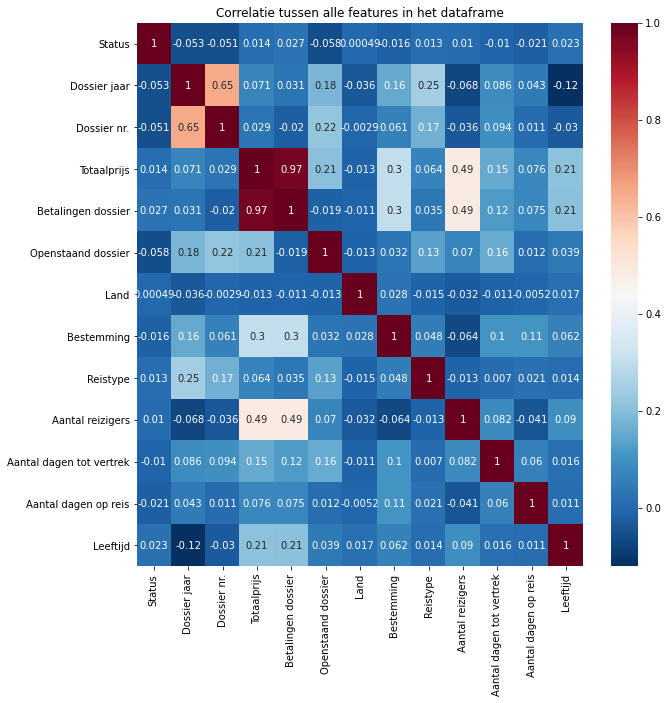

In [8]:
plt.figure(figsize=(10,10))
plt.title('Correlatie tussen alle features in het dataframe')
seaborn.heatmap((features).corr(), annot=True, cmap="RdBu_r")
plt.show();

## Selecteren van het meest interessante model

In de volgende stappen worden enkele modellen getest om te zien hoe de modellen het doen op de train en test data.

### KNN

KNN is het eenvoudigste model. Het onthoudt de trainingsgegevens en zet de te voorspellen gegevens op dezelfde grafiek. Om elk doel te voorspellen, zoekt het KNN-model het dichtstbijzijnde punt in de traingsdata en stelt de waarde van het te voorspellen gegeven in op dat van de dichtstbijzijnde buur. Er kan ingesteld worden hoeveel buren het model moet bevatten om een waarde aan het doel te geven. Meer of minder buren kiezen kan een goede of slechte invloed hebben op het classificerings model.

### Decision tree

Een decision tree is een algoritme dat gebruikmaakt van een boomachtig model om beslissingen te maken en hun mogelijke gevolgen te gaan afwegen. Het is een algoritme dat alleen voorwaardelijke controle-instructies bevat en op basis daarvan tot een voorspelling komt.

Decision trees hebben 2 hoofdzakelijke types:

* Classification tree is wanneer de voorspelde uitkomst de klasse is waartoe de gegevens behoren.
* Regression is wanneer de voorspelde uitkomst als een reëel getal kan worden beschouwd (bijvoorbeeld de prijs van een huis of de leeftijd van een persoon).

### Opsplitsen van train en test data

Onderstaande code splitst de data op in train en test data. In dit geval wordt de data opgesplitst volgens de standaard 75% train data en 25% test data. De niet numerieke kolommen worden uit de dataset weggelaten en de target wordt ingsteld in de 'y' array.

In [9]:
y = features['Aantal dagen tot vertrek'].to_numpy().astype(int)
X = features.drop(['Aantal dagen tot vertrek', 'Klantnummer', 'Geboortedatum', 'Dossier nr.', 'Betalingen dossier',  'Datum creatie', 'Datum vertrek', 'Datum terug'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
X

,Status,Dossier jaar,Totaalprijs,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen op reis,Leeftijd
0,1,2011,1600.00,0.0,2,2,1,6,2,40.0
1,1,2011,1600.00,0.0,2,2,1,6,2,40.0
2,1,2011,941.66,0.0,2,4,1,2,25,55.0
3,1,2011,7201.50,0.0,2,6,1,3,131,40.0
4,1,2011,4291.68,0.0,1,10,1,3,9,60.0
...,...,...,...,...,...,...,...,...,...,...
3957,1,2021,335.00,335.0,2,2,9,1,61,54.0
3958,1,2021,1020.00,1020.0,1,3,1,2,7,21.0
3959,1,2021,760.00,760.0,2,2,9,2,122,47.0
3960,0,2021,1076.10,1076.1,2,3,1,2,212,40.0


De vorm van de 'X' en 'y' array wordt hieronder afgeprint. De X dataset bevat 10 features (kolommen) en 3962 rijen, de y array bevat de target data met 1 kolom en 3962 rijen aan data.

In [11]:
print("Shape van de X data:", X.shape)
print("Shape van de y target data:", y.shape)

Shape van de X data: (3962, 10)
Shape van de y target data: (3962,)


## modellen evalueren en vergelijken

### Het KNN-model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage per aantal neighbors op de hele trainingsset. De twee rechtse grafieken tonen het percentage per aantal neighbors op de testdata. Hieruit blijkt dat op de trainingsdata het slaagpercentage afzwakt naarmate er meer neighbors bijkomen. Wat opvalt is dat bij 1 en 2 neightbors bij de trainingsset tegenover de testset er duidelijk overfitting optreedt.

Ik gebruik de Elbow methode om de beste waarde voor k (aantal neightbors) te vinden, deze waarde is dan af te lezen van de grafiek en wordt uitgeprint voor iedere iteratie met de bijhorende train en test scores. In mijn opstelling zal deze later ingesteld worden op 3, nadien doen we voor de evaluatie van het model nogmaals dezelfde stappen maar deze keer met een niet variable k.

Iteratie: 1
Accuracy on training set: 0.964
Accuracy on test set: 0.044
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.506
Accuracy on test set: 0.038
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.370
Accuracy on test set: 0.039
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.296
Accuracy on test set: 0.036
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.250
Accuracy on test set: 0.036
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.224
Accuracy on test set: 0.032
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.202
Accuracy on test set: 0.028
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.177
Accuracy on test set: 0.027
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.162
Accuracy on test set: 0.025
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.149
A

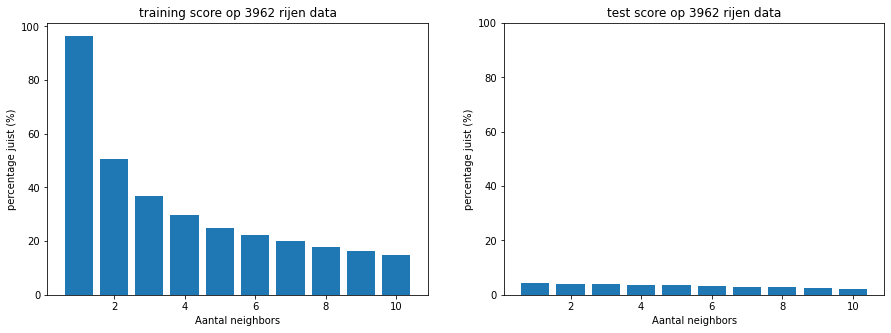

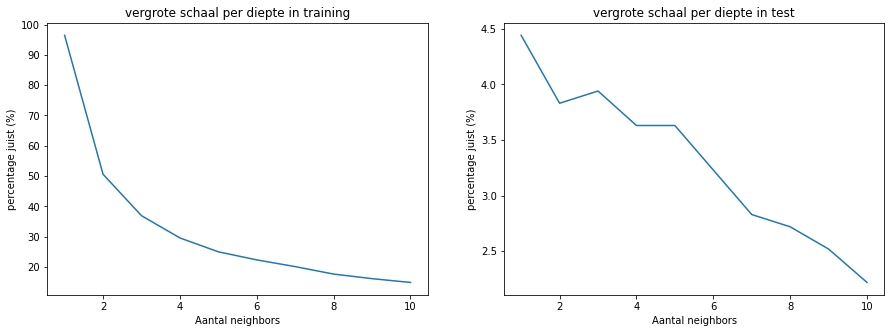

In [12]:
trainingScore = []
testScore = []
neighbors = 10

for k in range(1, neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    
    trainingScore.append(round(knn.score(X_train, y_train) * 100, 2))
    testScore.append(round(knn.score(X_test, y_test) * 100, 2))
    print("Iteratie: " + str(k))
    print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))
    print("*-------------------------------*")

    
#nieuwe voorspellingen worden gemaakt a.d.h.v. het model
#prediction = knn.predict(X_new)
#print("Prediction:", prediction)
#print("Predicted target name:", iris_dataset['target_names'][prediction])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, neighbors + 1)

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('test score op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(objects, trainingScore)
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.plot(objects, testScore)
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')
plt.show()

### Finaal KNN-model met vaste k

We zien hieronder een duidelijke overfitting optreden (dit wil zeggen een beter prestatie van het model op de trainingsset als op de testset). De k waarde is al zo optimaal mogelijk gekozen wat met een te kort aan features op een te kleine dataset moeilijk maakt.

In [13]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
trainingScore = round(knn.score(X_train, y_train), 2)
testScore = round(knn.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScore))
print("Test set score: " + str(testScore))
#print("\nClassification report:")
#print(classification_report(y_test, pred))

Training set score: 0.37
Test set score: 0.04


### Het decision tree classifier model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage voor elke diepte op de hele trainingsset. De twee rechtse grafieken tonen het percentage van de testdata voor elke diepte. Hieruit blijkt dat op de trainingsdata het slaagpercentage toeneemt bij een hogere diepte. Op de testdata stijgt de score tot aan een diepte van 6 waarna het terug afneemt. het slaagpercentage is opnieuw niet veel hoger dan bij KNN (maximaal 30% bij decision tree).

Iteratie: 1
Accuracy on training set: 0.011
Accuracy on test set: 0.009
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.013
Accuracy on test set: 0.003
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.015
Accuracy on test set: 0.009
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.018
Accuracy on test set: 0.008
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.023
Accuracy on test set: 0.013
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.029
Accuracy on test set: 0.017
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.037
Accuracy on test set: 0.016
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.050
Accuracy on test set: 0.022
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.067
Accuracy on test set: 0.024
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.088
A

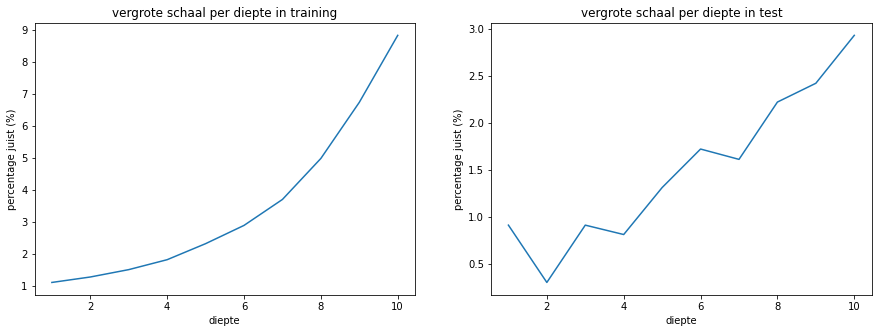

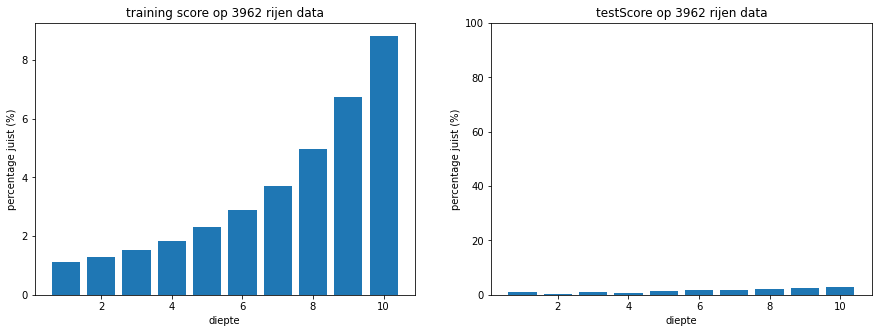

In [14]:
trainingScore = []
testScore = []
depth = 10

for n in range(1, depth + 1):
    treeModel = DecisionTreeClassifier(max_depth=n, random_state=42).fit(X_train, y_train)
    
    trainingScore.append(round(treeModel.score(X_train, y_train) * 100, 2))
    testScore.append(round(treeModel.score(X_test, y_test) * 100, 2))
    print("Iteratie: " + str(n))
    print("Accuracy on training set: {:.3f}".format(treeModel.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(treeModel.score(X_test, y_test)))
    print("*-------------------------------*")
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, depth + 1)

ax1.plot(objects, trainingScore)
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.plot(objects, testScore)
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte')
plt.show()

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import numpy as np

target = ['Status', 'Dossier jaar','Dossier nr.','Totaalprijs','Betalingen dossier','Openstaand dossier','Land','Bestemming','Reistype','Aantal reizigers','Aantal dagen tot vertrek']


#fig.savefig('tree.png')
#fig.savefig('DecisionTree.png')

### Logistic regression
# Tekst aanpassen!

Dit is een lineair model voor classificatie. *Solver* is het algoritme dat gebruikt wordt, dit is hier ingesteld op *liblinear* aangezien dit een multiclass dataset aankan, het enige wat we hier hebben is dat dit algoritme enkel 1 vs de rst kan. Wat inhoud dat de categorie ingedeeld worden in categorieA en de rest, dit wordt uitgevoerd en vervolgens indien het in de rest thuishoort deze stap wordt herhaalt (soort binaire classificatie dus die aan de basis ligt). 

De beste parameters voor het model worden gekozen via *GridSearch* in combinatie met *Cross validation*. In deze combinatie kan het model algemener getest worden en is de bias door algoritme zo klein mogelijk. We zien in dit model geen over- of underfitting. De accuracy op de test is hetzelfde als op de training, al ligt deze wel aan de lage kant. Ook hier ga ik in een verder evaluatie nog met de features experimenteren om dit omhoog te krijgen. Dit doe ik ook via feature selection methoden, zoals Principal component en singular value decomposition.

Bespreking van de matrix:
- 605 files zijn toegewezen aan het juiste type route
- 325 files in totaal van foutief toegewezen
- het model heeft dus in totaal 930 files gebruikt voor te testen

Het raport kan afgelezen worden op dezelfde manier als bij het KNN-model

In [16]:
logRegr = LogisticRegression(solver='liblinear', max_iter=500, multi_class = 'auto')
logRegr.fit(X_train, y_train)

print('training score: ',str(round(logRegr.score(X_train, y_train) * 100, 2)) + '%')
print('test score: ', str(round(logRegr.score(X_test, y_test) * 100, 2)) + '%')

training score:  4.11%
test score:  1.01%


In [ ]:
#fill parameter grid for this model
param_grid = {'random_state': [0, 1, 2, 3, 4, 5]}

#do a gridsearchCV, this will decide the best parameters for the model 
#and usses a validation set to minimalize overfitting of the training set
gridSearchLogReg = GridSearchCV(LogisticRegression(solver="liblinear", multi_class="auto"), param_grid, cv=5, return_train_score=True)

gridSearchLogReg.fit(X_train, y_train)
pred = gridSearchLogReg.predict(X_test)
trainingScoreLogReg = round(gridSearchLogReg.score(X_train, y_train), 2)
testScoreLogReg = round(gridSearchLogReg.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScoreLogReg))
print("Test set score: " + str(testScoreLogReg))

print("Best parameters: {}".format(gridSearchLogReg.best_params_))
print("Best cross-validation score: {:.2f}".format(gridSearchLogReg.best_score_))

#print("\nConfusion matrix:")
#print(confusion_matrix(y_test,pred))
#print("\nClassification report:")
#print(classification_report(y_test,pred))

### cross-validation

Cross validatie is een techniek om te beschermen tegen overfitting in een model. Bij cross validatie wordt er een vast aantal folds (of partities) van de gegevens genomen, daarop wordt de analyse uitgevoerd op elke fold en een gemiddelde van de totale foutschatting berekend.

Deze techniek wordt hieronder uitgevoerd met KNN (k-nearest neighbors), Linaire regressie en Decision tree.

In [23]:
kFold = KFold(n_splits=10, shuffle=True, random_state=42)

KNN = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

df_knn = pd.DataFrame(cross_validate(KNN, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(KNN, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_knn

Average cross-validation score: 0.02


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,fit_time,score_time,test_score,train_score
0,0.007629,0.018555,0.035264,0.245442
1,0.007567,0.021251,0.030227,0.245161
2,0.007620,0.018365,0.030303,0.247897
3,0.007357,0.016052,0.022727,0.245934
4,0.005996,0.013874,0.025253,0.243971
5,0.005722,0.013092,0.045455,0.247897
6,0.005820,0.013190,0.040404,0.244812
7,0.005709,0.012988,0.037879,0.249860
8,0.005867,0.013384,0.025253,0.244251
9,0.005860,0.013329,0.030303,0.244251


In [22]:
linair = LinearRegression().fit(X_train, y_train)

df_lin = pd.DataFrame(cross_validate(linair, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(linair, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_lin

Average cross-validation score: -0.00


,fit_time,score_time,test_score,train_score
0,0.003552,0.001645,0.059075,0.048892
1,0.003572,0.002031,0.005493,0.054643
2,0.003148,0.002121,0.045198,0.050026
3,0.003549,0.002113,0.040855,0.049763
4,0.003323,0.001975,-0.014737,0.055972
5,0.002884,0.002188,0.052443,0.049420
6,0.003269,0.002024,0.053330,0.049212
7,0.002407,0.001366,0.053652,0.049210
8,0.002779,0.001342,0.068803,0.047574
9,0.002317,0.001602,0.040085,0.050421


In [33]:
decTree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

df_dec = pd.DataFrame(cross_validate(decTree, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(decTree, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_dec

Average cross-validation score: 0.01


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,fit_time,score_time,test_score,train_score
0,0.035569,0.002498,0.007557,0.017952
1,0.031751,0.002181,0.000000,0.021038
2,0.035082,0.002586,0.005051,0.021312
3,0.038479,0.002202,0.020202,0.022715
4,0.038759,0.002387,0.015152,0.021873
5,0.036385,0.002312,0.007576,0.021873
6,0.037306,0.002122,0.017677,0.016826
7,0.036365,0.002348,0.017677,0.020752
8,0.037029,0.002102,0.010101,0.023836
9,0.035867,0.002276,0.002525,0.022434


In [19]:
#scatter_matrix(df, figsize=(10, 10))
#plt.show()

In [20]:
#print("Average cross-validation score: {:.2f}".format(scores.mean()))